In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import math
#from skimpy import skim

from sklearn.preprocessing import MultiLabelBinarizer

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import matplotlib as mlp

sns.set_theme(style='darkgrid', palette='mako')

mlp.rcParams['axes.labelsize'] = 10
mlp.rcParams['axes.titlesize'] = 15

In [4]:
pd.options.display.max_columns = 500
pd.options.display.max_rows = 100

In [5]:
RANDOM = 42

# LOADING DATA

In [6]:
cargotype_info = pd.read_csv('data/cargotype_info.csv', index_col='Unnamed: 0')
carton_price = pd.read_excel('data/carton_price.xlsx')
carton = pd.read_csv('data/carton.csv')
data = pd.read_csv('data/data.csv', index_col='Unnamed: 0')
sku_cargotypes = pd.read_csv('data/sku_cargotypes.csv', index_col='Unnamed: 0')
sku = pd.read_csv('data/sku.csv', index_col='Unnamed: 0')

In [7]:
mb_not_important = [690, 691, 692, 931, 930, 350, 920, 292, 291, 290, 303, 302, 110, 752, 751, 410, 799, 20, 400, 0, 780, 760, 510, 150, 790, 950, 990, 985, 301]

carton_price.columns = ['cartontype', 'price']
carton.columns = [s.lower() for s in carton.columns]

In [8]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

In [9]:
corr_test = pd.merge(sku_cargotypes, data[['sku', 'selected_cartontype']], on='sku', how='left')

In [10]:
corr_test['selected_cartontype'] = label_encoder.fit_transform(corr_test['selected_cartontype'])

In [11]:
corr_test[['cargotype', 'selected_cartontype']].corr() # корреляция категория тип упаковки

,cargotype,selected_cartontype
cargotype,1.000000,0.021945
selected_cartontype,0.021945,1.000000


In [12]:
sku_cargotypes_filtred = pd.merge(data[['sku']].drop_duplicates(), sku_cargotypes, on='sku', how='left') # дропаем тех которых у нас нет
#sku_cargotypes_filtred = sku_cargotypes_filtred.query('cargotype not in @mb_not_important') # дропаем как мне кажется не особо важные
sku_groups = sku_cargotypes_filtred.groupby('sku')['cargotype'].apply(list).reset_index()
#sku_groups = pd.merge(data[['sku']].drop_duplicates(), sku_groups, on='sku', how='left') # 
sku_groups.head()

,sku,cargotype
0,00001dba9dfe01a550c23064c2b8e96f,[nan]
1,000198cfae123aef536f2fcf0b104049,"[290.0, 310.0, 410.0, 720.0, 750.0, 770.0]"
2,0003da69535758c817b78b64da05aae0,"[290.0, 310.0, 340.0, 750.0]"
3,0003fb4df9f32661d8772b1eac96e5ea,"[290.0, 600.0, 610.0, 950.0, 960.0, 970.0, 980.0]"
4,0005b21e4cba70e646f9f8f9a5d88d4e,"[290.0, 440.0, 441.0, 480.0, 490.0, 520.0, 690.0]"


In [13]:
def gen_geometry_feat(df, a, b, c):
    '''
    генерим геометрические фичи
    a, b, c -- размеры
    '''
    df['dim_sum'] = df[[a, b, c]].sum(axis=1)
    df['vol'] = np.floor(df[[a, b, c]].prod(axis=1))
    df['dim_mean'] = np.floor(df[[a, b, c]].mean(axis=1))
    df['dim_median'] = np.floor(df[[a, b, c]].median(axis=1))

    df['prod_a_b'] = np.floor(df[[a, b]].prod(axis=1))
    df['prod_a_c'] = np.floor(df[[a, c]].prod(axis=1))
    df['prod_b_c'] = np.floor(df[[b, c]].prod(axis=1))
    
    df['prod_min'] = df[['prod_a_b', 'prod_a_c', 'prod_b_c']].min(axis=1)
    df['prod_mean'] = np.floor(df[['prod_a_b', 'prod_a_c', 'prod_b_c']].mean(axis=1))

    df['diag'] = round(np.sqrt(df[a]**2 + df[b]**2 + df[c]**2), 1)
    return df

In [14]:
sku = gen_geometry_feat(sku, 'a', 'b', 'c')
carton = gen_geometry_feat(carton, 'length', 'width', 'height')

In [15]:
non_volume = ['KSD', 'NONPACK', 'STRETCH'] # нулевой объем помешает потом

In [16]:
# фичи для упаковок, для сравнения с фичами заказа
new_carton = carton.query('cartontype not in @non_volume').set_index('cartontype').unstack().reset_index()
new_carton = new_carton.rename(
    columns={
        'level_0': 'carton_dim',
        0: 'value'
})

new_carton['carton_type_dim'] = new_carton['carton_dim'] + '_' + new_carton['cartontype']
new_carton = new_carton.drop(['carton_dim', 'cartontype'], axis=1)
new_carton_t =  new_carton.set_index('carton_type_dim').T

In [17]:
df = data.copy()

In [18]:
cols_to_drop = ['who', # Лишняя информация
                'trackingid', # Лишняя информация для обучения
                'recommended_cartontype', # Работа прошлого алгоритма - для обучения лишняя инфа
                'recommended_carton', # Дубликат
                'selected_cartontype', # Дубликат 
                'rec_calc_cube', # Результат предсказания
                #'orderkey', 
                'whs' # Не влияет на задачу
                ]

In [19]:
df = df.drop(cols_to_drop, axis=1)
df.head()

,orderkey,box_num,selected_carton,sel_calc_cube,pack_volume,goods_wght,sku
0,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.1,af49bf330e2cf16e44f0be1bdfe337bd
1,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.1,af49bf330e2cf16e44f0be1bdfe337bd
2,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.1,af49bf330e2cf16e44f0be1bdfe337bd
3,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.1,af49bf330e2cf16e44f0be1bdfe337bd
4,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.1,af49bf330e2cf16e44f0be1bdfe337bd


In [20]:
# не хватает оперативки

# mlb = MultiLabelBinarizer()
# one_hot = mlb.fit_transform(sku_groups['cargotype'])

# one_hot_df = pd.DataFrame(one_hot, columns=mlb.classes_)
# one_hot_df['sku'] = sku_groups['sku']
# df = pd.merge(df, one_hot_df, on='sku', how='left')

In [21]:
sku = sku[sku['vol']>0]

In [22]:
df = pd.merge(df, sku, on='sku', how='left')
df = df.rename(columns={'vol':'sku_vol', 
                        'a':'sku_a', 
                        'b': 'sku_b',
                        'c': 'sku_c'})

df.head(3)

,orderkey,box_num,selected_carton,sel_calc_cube,pack_volume,goods_wght,sku,sku_a,sku_b,sku_c,dim_sum,sku_vol,dim_mean,dim_median,prod_a_b,prod_a_c,prod_b_c,prod_min,prod_mean,diag
0,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.1,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0,48.0,2046.0,16.0,11.0,66.0,341.0,186.0,66.0,197.0,33.4
1,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.1,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0,48.0,2046.0,16.0,11.0,66.0,341.0,186.0,66.0,197.0,33.4
2,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.1,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0,48.0,2046.0,16.0,11.0,66.0,341.0,186.0,66.0,197.0,33.4


In [23]:
df.isna().sum()

orderkey               0
box_num                0
selected_carton        0
sel_calc_cube          0
pack_volume            0
goods_wght             0
sku                    0
sku_a              10899
sku_b              10899
sku_c              10899
dim_sum            10899
sku_vol            10899
dim_mean           10899
dim_median         10899
prod_a_b           10899
prod_a_c           10899
prod_b_c           10899
prod_min           10899
prod_mean          10899
diag               10899
dtype: int64

In [24]:
df = df.dropna()
#df = df.query('goods_wght!=0') # metrics 0.3

In [25]:
df

,orderkey,box_num,selected_carton,sel_calc_cube,pack_volume,goods_wght,sku,sku_a,sku_b,sku_c,dim_sum,sku_vol,dim_mean,dim_median,prod_a_b,prod_a_c,prod_b_c,prod_min,prod_mean,diag
0,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.100,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0,48.0,2046.0,16.0,11.0,66.0,341.0,186.0,66.0,197.0,33.4
1,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.100,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0,48.0,2046.0,16.0,11.0,66.0,341.0,186.0,66.0,197.0,33.4
2,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.100,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0,48.0,2046.0,16.0,11.0,66.0,341.0,186.0,66.0,197.0,33.4
3,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.100,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0,48.0,2046.0,16.0,11.0,66.0,341.0,186.0,66.0,197.0,33.4
4,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.100,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0,48.0,2046.0,16.0,11.0,66.0,341.0,186.0,66.0,197.0,33.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325618,0e4f34db53e37d6bf171c2e055e2b4e0,1,MYC,4560,2080,0.100,86dcc1a44eb2939fea4d2dd3604e1f9e,26.0,20.0,4.0,50.0,2080.0,16.0,20.0,520.0,104.0,80.0,80.0,234.0,33.0
325619,0e4f34db53e37d6bf171c2e055e2b4e0,1,MYC,4560,2080,0.100,86dcc1a44eb2939fea4d2dd3604e1f9e,26.0,20.0,4.0,50.0,2080.0,16.0,20.0,520.0,104.0,80.0,80.0,234.0,33.0
325620,e71d2e750ce9a7a39c273c634be1665d,1,YMC,8525,3523,0.284,9db21acf9e6c1a66493c246c1461f989,11.4,10.2,30.3,51.9,3523.0,17.0,11.0,116.0,345.0,309.0,116.0,256.0,33.9
325621,2e2a642f611b5a6f2c404ab945fbc2a3,1,MYB,2816,552,0.230,4aedb72c5662562524f6119918c7179b,23.0,2.0,12.0,37.0,552.0,12.0,12.0,46.0,276.0,24.0,24.0,115.0,26.0


In [26]:
df_sum = df.groupby('orderkey', sort=False).sum() # суммируем по заказам

In [27]:
df_sum

,box_num,sel_calc_cube,pack_volume,goods_wght,sku_a,sku_b,sku_c,dim_sum,sku_vol,dim_mean,dim_median,prod_a_b,prod_a_c,prod_b_c,prod_min,prod_mean,diag
orderkey,,,,,,,,,,,,,,,,,
d48f3211c1ffccdc374f23139a9ab668,64,0,83886,4.100,451.0,246.0,1271.0,1968.0,83886.0,656.0,451.0,2706.0,13981.0,7626.0,2706.0,8077.0,1369.4
4b33fcc98ea1f59d6fe4eb2e0a48bb4b,1,0,3050,0.896,18.6,3.3,49.7,71.6,3050.0,23.0,18.0,61.0,924.0,164.0,61.0,383.0,53.2
3e646181f6f708edd3326c1626c12d23,1,0,13662,4.400,30.0,23.0,22.0,75.0,15180.0,25.0,23.0,690.0,660.0,506.0,506.0,618.0,43.7
7047c16a6b7c120162ca3da0ebca43fd,1,0,4518,0.700,14.0,10.7,43.8,68.5,6561.0,22.0,14.0,149.0,613.0,468.0,149.0,410.0,47.2
097917e584151c0c21f205b2c3aafa10,1,0,6346,2.078,23.4,8.0,33.9,65.3,6346.0,21.0,23.0,187.0,793.0,271.0,187.0,417.0,42.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8ed0af8473526c54b4b2f99f0060c3ea,2,0,50336,2.520,88.0,26.0,88.0,202.0,50336.0,66.0,88.0,1144.0,3872.0,1144.0,1144.0,2052.0,127.2
0e4f34db53e37d6bf171c2e055e2b4e0,2,9120,4160,0.200,52.0,40.0,8.0,100.0,4160.0,32.0,40.0,1040.0,208.0,160.0,160.0,468.0,66.0
e71d2e750ce9a7a39c273c634be1665d,1,8525,3523,0.284,11.4,10.2,30.3,51.9,3523.0,17.0,11.0,116.0,345.0,309.0,116.0,256.0,33.9


In [28]:
# возвращаем потеряный таргет
order_pack = df[['orderkey', 'selected_carton']].drop_duplicates()
df_sum = pd.merge(df_sum, order_pack, on= 'orderkey', how='left')

In [29]:
# добавляем максимальные размеры одного товара
df_grouped = df.groupby('orderkey', sort=False)[['sku_a', 'sku_b', 'sku_c', 'goods_wght']].max().reset_index() 
df_grouped['sku_max_size'] = df_grouped[['sku_a', 'sku_b', 'sku_c']].sum(axis=1) # df_grouped[['sku_a', 'sku_b', 'sku_c']].max(axis=1)
df_grouped['sku_mean_size'] = df_grouped[['sku_a', 'sku_b', 'sku_c']].mean(axis=1) # df_grouped[['sku_a', 'sku_b', 'sku_c']].max(axis=1)
df_grouped['sku_prod_size'] = df_grouped[['sku_a', 'sku_b', 'sku_c']].prod(axis=1) # df_grouped[['sku_a', 'sku_b', 'sku_c']].max(axis=1)
# ratio max к остальным
df_grouped['sku_ratio_max_a'] = round(np.divide(df_grouped[['sku_a', 'sku_b', 'sku_c']].max(axis=1), df_grouped['sku_a']), 1)
df_grouped['sku_ratio_max_b'] = round(np.divide(df_grouped[['sku_a', 'sku_b', 'sku_c']].max(axis=1), df_grouped['sku_b']), 1)
df_grouped['sku_ratio_max_c'] = round(np.divide(df_grouped[['sku_a', 'sku_b', 'sku_c']].max(axis=1), df_grouped['sku_c']), 1)
# weight
df_grouped['dens'] = round(np.divide(df_grouped['goods_wght']*10**4, df_grouped['sku_prod_size']), 1)
df_grouped['wght_max_len'] = round(np.divide(df_grouped['goods_wght']*10**3, df_grouped[['sku_a', 'sku_b', 'sku_c']].max(axis=1)), 1)

df_grouped['sku_max_diag'] = round(np.sqrt(df_grouped['sku_a']**2 + df_grouped['sku_b']**2 + df_grouped['sku_c']**2), 1)
df_grouped['sku_max_diag'] = round(np.sqrt(df['sku_a']**2 + df['sku_b']**2 + df['sku_c']**2), 1)

df_sum = pd.merge(df_sum, df_grouped[['orderkey', 'sku_max_size', 'sku_mean_size', 
                                  'sku_prod_size', 'sku_ratio_max_a', 'sku_ratio_max_b', 
                                  'sku_ratio_max_c', 'dens', 'wght_max_len', 'sku_max_diag']], on='orderkey', how='left')

In [30]:
df_sum

,orderkey,box_num,sel_calc_cube,pack_volume,goods_wght,sku_a,sku_b,sku_c,dim_sum,sku_vol,dim_mean,dim_median,prod_a_b,prod_a_c,prod_b_c,prod_min,prod_mean,diag,selected_carton,sku_max_size,sku_mean_size,sku_prod_size,sku_ratio_max_a,sku_ratio_max_b,sku_ratio_max_c,dens,wght_max_len,sku_max_diag
0,d48f3211c1ffccdc374f23139a9ab668,64,0,83886,4.100,451.0,246.0,1271.0,1968.0,83886.0,656.0,451.0,2706.0,13981.0,7626.0,2706.0,8077.0,1369.4,NONPACK,48.0,16.000000,2046.000,2.8,5.2,1.0,0.5,3.2,33.4
1,4b33fcc98ea1f59d6fe4eb2e0a48bb4b,1,0,3050,0.896,18.6,3.3,49.7,71.6,3050.0,23.0,18.0,61.0,924.0,164.0,61.0,383.0,53.2,STRETCH,71.6,23.866667,3050.586,2.7,15.1,1.0,2.9,18.0,33.4
2,3e646181f6f708edd3326c1626c12d23,1,0,13662,4.400,30.0,23.0,22.0,75.0,15180.0,25.0,23.0,690.0,660.0,506.0,506.0,618.0,43.7,STRETCH,75.0,25.000000,15180.000,1.0,1.3,1.4,2.9,146.7,33.4
3,7047c16a6b7c120162ca3da0ebca43fd,1,0,4518,0.700,14.0,10.7,43.8,68.5,6561.0,22.0,14.0,149.0,613.0,468.0,149.0,410.0,47.2,STRETCH,68.5,22.833333,6561.240,3.1,4.1,1.0,1.1,16.0,33.4
4,097917e584151c0c21f205b2c3aafa10,1,0,6346,2.078,23.4,8.0,33.9,65.3,6346.0,21.0,23.0,187.0,793.0,271.0,187.0,417.0,42.0,STRETCH,65.3,21.766667,6346.080,1.4,4.2,1.0,3.3,61.3,33.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155344,8ed0af8473526c54b4b2f99f0060c3ea,2,0,50336,2.520,88.0,26.0,88.0,202.0,50336.0,66.0,88.0,1144.0,3872.0,1144.0,1144.0,2052.0,127.2,NONPACK,101.0,33.666667,25168.000,1.0,3.4,1.0,0.5,28.6,24.6
155345,0e4f34db53e37d6bf171c2e055e2b4e0,2,9120,4160,0.200,52.0,40.0,8.0,100.0,4160.0,32.0,40.0,1040.0,208.0,160.0,160.0,468.0,66.0,MYC,50.0,16.666667,2080.000,1.0,1.3,6.5,0.5,3.8,10.2
155346,e71d2e750ce9a7a39c273c634be1665d,1,8525,3523,0.284,11.4,10.2,30.3,51.9,3523.0,17.0,11.0,116.0,345.0,309.0,116.0,256.0,33.9,YMC,51.9,17.300000,3523.284,2.7,3.0,1.0,0.8,9.4,23.6
155347,2e2a642f611b5a6f2c404ab945fbc2a3,1,2816,552,0.230,23.0,2.0,12.0,37.0,552.0,12.0,12.0,46.0,276.0,24.0,24.0,115.0,26.0,MYB,37.0,12.333333,552.000,1.0,11.5,1.9,4.2,10.0,23.5


In [ ]:
# df = df_sum.dropna().reset_index(drop=True)
#df = df[df['selected_carton']!='YMB']
# df[df['selected_carton'] =='YMB']

In [ ]:
# создаем столбцы с размерами коробок пока объем и диагонали(feature_importance считает что они важны)
df_sum[new_carton_t.filter(like='vol').columns.tolist()] = new_carton_t[new_carton_t.filter(like='vol').columns.tolist()].values.reshape(-1,1).flatten().tolist()
df_sum[new_carton_t.filter(like='diag').columns.tolist()] = new_carton_t[new_carton_t.filter(like='diag').columns.tolist()].values.reshape(-1,1).flatten().tolist()

In [ ]:
df_sum.head(3)

In [ ]:
# hard code
def diff(row):
    '''
    отношение диагонали к каждой из диагоналей всех коробок
    '''
    return row['diag'] / row[new_carton_t.filter(like='diag').columns.tolist()]


df_sum[new_carton_t.filter(like='diag').columns.tolist()] = df_sum.apply(diff, axis=1)

In [ ]:
def diff(row):
    '''
    отношение объема к каждой из диагоналей всех коробок
    '''
    return row['sku_vol'] / row[new_carton_t.filter(like='vol').columns.tolist()]


df_sum[new_carton_t.filter(like='vol').columns.tolist()] = df_sum.apply(diff, axis=1)

In [ ]:
df = df.drop('orderkey', axis=1)

In [ ]:
df

<Axes: >

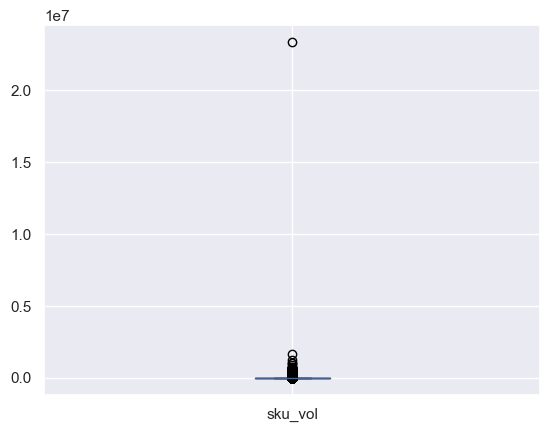

In [89]:
df_sum['sku_vol'].plot(kind='box')

In [90]:
# дроп выбросов по объему
q1 = df_sum['sku_vol'].quantile(0.25)
q3 = df_sum['sku_vol'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

df_no_outlier_vol = df_sum[(df_sum['sku_vol'] >= lower_bound) & (df_sum['sku_vol'] <= upper_bound)]

<Axes: >

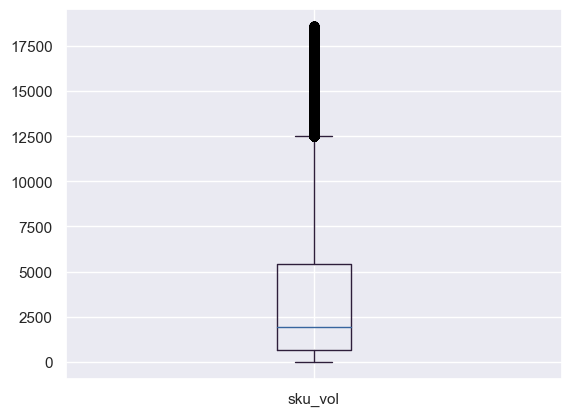

In [91]:
df_no_outlier_vol['sku_vol'].plot(kind='box')

In [ ]:
# для категорий товаров
# df.describe()
# cols_zero_max = df.describe().columns[df.describe().loc['max'] == 0]
# cols_zero_max
# df = df.drop(cols_zero_max, axis=1)

In [ ]:
df_no_outlier_vol

In [ ]:
numeric_columns = df.loc[:,df.dtypes!=np.object_].columns

plt.figure(figsize=(12, 10))
sns.heatmap(df_no_outlier_vol[numeric_columns].corr(), 
            annot=True, 
            vmin=0, 
            vmax=1, 
            center=0, 
            cmap='coolwarm', 
            square=True);

In [ ]:
corr_feat = set()
corr_matrix = df_no_outlier_vol.corr()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.85:
            colname = corr_matrix.columns[i]
            corr_feat.add(colname)       
corr_feat

In [ ]:
fltr_nonpack =  ["STRETCH", "NONPACK"]

In [ ]:
df_no_outlier_vol_nonpack = df_no_outlier_vol.query('selected_carton not in @fltr_nonpack')

In [ ]:
df_no_outlier_vol_nonpack

In [ ]:
# Проверить
df_no_outlier_vol = df_no_outlier_vol.drop(corr_feat, axis=1)

# Модель

In [34]:
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score, accuracy_score

In [ ]:
from fedot.api.main import Fedot

In [ ]:
auto_model = Fedot(
    problem='classification',
    timeout=10,
    cv_folds=10,
    metric='roc_auc',
    n_jobs=-1,
    preset='best_quality',
    seed=42
)

In [ ]:
auto_model.fit(features=X_train, target=y_train)

In [ ]:
df_sum['selected_carton'].value_counts()


In [ ]:
df_sum

In [73]:
df_no_outlier_vol = df_no_outlier_vol.query('selected_carton != "YMB"')

In [92]:
df_no_outlier_vol

,orderkey,box_num,sel_calc_cube,pack_volume,goods_wght,sku_a,sku_b,sku_c,dim_sum,sku_vol,dim_mean,dim_median,prod_a_b,prod_a_c,prod_b_c,prod_min,prod_mean,diag,selected_carton,sku_max_size,sku_mean_size,sku_prod_size,sku_ratio_max_a,sku_ratio_max_b,sku_ratio_max_c,dens,wght_max_len,sku_max_diag
1,4b33fcc98ea1f59d6fe4eb2e0a48bb4b,1,0,3050,0.896,18.6,3.3,49.7,71.6,3050.0,23.0,18.0,61.0,924.0,164.0,61.0,383.0,53.2,STRETCH,71.6,23.866667,3050.586,2.7,15.1,1.0,2.9,18.0,33.4
2,3e646181f6f708edd3326c1626c12d23,1,0,13662,4.400,30.0,23.0,22.0,75.0,15180.0,25.0,23.0,690.0,660.0,506.0,506.0,618.0,43.7,STRETCH,75.0,25.000000,15180.000,1.0,1.3,1.4,2.9,146.7,33.4
3,7047c16a6b7c120162ca3da0ebca43fd,1,0,4518,0.700,14.0,10.7,43.8,68.5,6561.0,22.0,14.0,149.0,613.0,468.0,149.0,410.0,47.2,STRETCH,68.5,22.833333,6561.240,3.1,4.1,1.0,1.1,16.0,33.4
4,097917e584151c0c21f205b2c3aafa10,1,0,6346,2.078,23.4,8.0,33.9,65.3,6346.0,21.0,23.0,187.0,793.0,271.0,187.0,417.0,42.0,STRETCH,65.3,21.766667,6346.080,1.4,4.2,1.0,3.3,61.3,33.4
6,abea12f00a205457b289b2e5c0351e17,1,0,7569,6.080,29.0,9.0,29.0,67.0,7569.0,22.0,29.0,261.0,841.0,261.0,261.0,454.0,42.0,NONPACK,67.0,22.333333,7569.000,1.0,3.2,1.0,8.0,209.7,33.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155342,3acc4b901256bcd9f333b6978864773b,1,8525,4050,1.740,25.0,9.0,18.0,52.0,4050.0,17.0,18.0,225.0,450.0,162.0,162.0,279.0,32.1,YMC,52.0,17.333333,4050.000,1.0,2.8,1.4,4.3,69.6,24.6
155343,b2d5108421ce9c823a083fdaf870b9a2,6,130872,12510,1.236,251.4,12.6,142.2,406.2,12510.0,132.0,138.0,522.0,5958.0,294.0,294.0,2256.0,289.2,YMW,67.7,22.566667,2085.363,1.0,20.0,1.8,1.0,4.9,24.6
155345,0e4f34db53e37d6bf171c2e055e2b4e0,2,9120,4160,0.200,52.0,40.0,8.0,100.0,4160.0,32.0,40.0,1040.0,208.0,160.0,160.0,468.0,66.0,MYC,50.0,16.666667,2080.000,1.0,1.3,6.5,0.5,3.8,10.2
155346,e71d2e750ce9a7a39c273c634be1665d,1,8525,3523,0.284,11.4,10.2,30.3,51.9,3523.0,17.0,11.0,116.0,345.0,309.0,116.0,256.0,33.9,YMC,51.9,17.300000,3523.284,2.7,3.0,1.0,0.8,9.4,23.6


In [94]:
X = df_no_outlier_vol.drop(['sel_calc_cube', 'box_num', 'pack_volume', 'selected_carton', 'orderkey'], axis=1)
X.columns = X.columns.astype(str)
y = df_no_outlier_vol['selected_carton']

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=RANDOM,
                                                    shuffle=True,
                                                    stratify=df_no_outlier_vol['selected_carton']
                                                    )

In [88]:
X_train

,goods_wght,sku_a,sku_b,sku_c,dim_sum,sku_vol,dim_mean,dim_median,prod_a_b,prod_a_c,prod_b_c,prod_min,prod_mean,diag
195207,0.700,10.1,10.0,20.7,40.8,2090.0,13.0,10.0,101.0,209.0,207.0,101.0,172.0,25.1
102759,0.250,4.5,17.0,4.5,26.0,344.0,8.0,4.0,76.0,20.0,76.0,20.0,57.0,18.2
234825,0.060,3.9,3.4,13.2,20.5,175.0,6.0,3.0,13.0,51.0,44.0,13.0,36.0,14.2
246963,0.361,18.1,5.6,16.2,39.9,1642.0,13.0,16.0,101.0,293.0,90.0,90.0,161.0,24.9
273751,0.180,20.0,5.0,5.0,30.0,500.0,10.0,5.0,100.0,100.0,25.0,25.0,75.0,21.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46720,0.060,3.0,14.0,4.0,21.0,168.0,7.0,4.0,42.0,12.0,56.0,12.0,36.0,14.9
1445,1.017,11.3,6.1,20.3,37.7,1399.0,12.0,11.0,68.0,229.0,123.0,68.0,140.0,24.0
32182,0.150,20.0,4.0,10.0,34.0,800.0,11.0,10.0,80.0,200.0,40.0,40.0,106.0,22.7
223543,0.290,6.0,6.0,18.0,30.0,648.0,10.0,6.0,36.0,108.0,108.0,36.0,84.0,19.9


In [36]:
# для нейронки
from sklearn.preprocessing import LabelEncoder
# Создаем объект LabelEncoder
label_encoder = LabelEncoder()

# Преобразуем столбец с классами в числа
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [37]:
from tensorflow.keras import Sequential

In [38]:
import keras
from tensorflow.keras import layers, callbacks

In [39]:
# from tensorflow.keras import Sequential
# from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
# from tensorflow.keras.optimizers import Adam
from keras.layers import LSTM
from keras.metrics import BinaryAccuracy, AUC

from keras.models import Sequential
#from tensorflow import keras
from keras.layers import Dense, SimpleRNN, Activation, Conv1D, Flatten, MaxPooling1D, Dropout, BatchNormalization
from keras import optimizers

In [ ]:
len(np.unique(y_test))

In [40]:
from keras.utils import to_categorical

# Convert labels to one-hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [49]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Embedding, LSTM, SpatialDropout1D


early_stopping = callbacks.EarlyStopping(
    min_delta=0.01, # minimium amount of change to count as an improvement
    patience=3, # how many epochs to wait before stopping
    restore_best_weights=True,
)

# Создание модели

model = Sequential()
#model.add(BatchNormalization())
model.add(Dense(512, activation='relu', input_shape=[X_train.shape[1]]))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(16, activation='softmax'))

adam = optimizers.Adam(learning_rate=0.1) #  0.0001 'optimizer': ['adadelta', 'rmsprop', 'adam'] learning_rate = 0.00001

# Compile the model
model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [50]:
# Train the model
history = model.fit(
    X_train,
    y_train,
    # np.asarray(X_train).astype(np.float32),
    # np.asarray(y_train).astype(np.float32),
    epochs=20, 
    batch_size=128,
    callbacks=[early_stopping],
    validation_data=(X_test, y_test))

Epoch 1/20
187/911 [=====>........................] - ETA: 9s - loss: nan - accuracy: 0.1019

KeyboardInterrupt: 

In [ ]:
# Evaluate the model on test data
score = model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', score[1])

In [ ]:
early_stopping = callbacks.EarlyStopping(
    min_delta=0.1, # minimium amount of change to count as an improvement
    patience=3, # how many epochs to wait before stopping
    restore_best_weights=True,
)


model = keras.Sequential([
    #layers.BatchNormalization(),
    layers.Dense(23, activation='relu', input_shape=[X_train.shape[1]]),
    # layers.Dense(X_train.shape[1], activation='relu'),
    # layers.Dense(X_train.shape[1], activation='relu'),
    # layers.Dense(X_train.shape[1], activation='relu'),
    # layers.Dense(X_train.shape[1], activation='relu'),
    # layers.Dense(X_train.shape[1], activation='relu'),
    # layers.Dense(X_train.shape[1], activation='relu'),
    # layers.Dense(X_train.shape[1], activation='relu'),
    # layers.Dropout(0.3),
    # layers.BatchNormalization(),
    # layers.Dense(X_train.shape[1], activation='relu'),    
    # layers.Dropout(0.3),
    # layers.BatchNormalization(),
    # layers.Dense(X_train.shape[1]//8, activation='relu'),
    # layers.Dropout(0.3),
    # layers.BatchNormalization(),
    # layers.Dense(X_train.shape[1]//16, activation='relu'),    
    # layers.Dropout(0.3),
    # layers.BatchNormalization(),
    # layers.Dense(X_train.shape[1]//32, activation='relu'),
    layers.Dense(23, activation='softmax'),
    #layers.Activation('sigmoid')
])

adam = optimizers.Adam(learning_rate=1) #  0.0001 'optimizer': ['adadelta', 'rmsprop', 'adam'] learning_rate = 0.00001

model.compile(
    optimizer=adam,
    #optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=64,
    epochs=50,
    verbose=1,
    callbacks=[early_stopping],
)

In [51]:
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import KNeighborsClassifier

In [85]:
from sklearn.utils.class_weight import compute_class_weight
 
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

In [106]:
tree_pipe = Pipeline([
    #('scaler', StandardScaler()),
    #('scaler', RobustScaler()),
    #('pca', PCA(n_components=16)),
    #('tree', KNeighborsClassifier(n_neighbors=8, p=1)),

    
    ('tree', CatBoostClassifier(
        random_state=42,
        early_stopping_rounds=100,
        #learning_rate=0.01, 
        leaf_estimation_method='Gradient',
        iterations=100,
        subsample=0.2,
        #max_depth=4,
        verbose=10,
        #l2_leaf_reg = 7,
        bootstrap_type="Bernoulli",
        #class_weights=class_weights,
        loss_function='MultiClass',
        eval_metric='TotalF1'
        ))
])

tree_pipe.fit(X_train, y_train)

0:	learn: 0.2437325	total: 650ms	remaining: 1m 4s
10:	learn: 0.2811542	total: 5.79s	remaining: 46.8s
20:	learn: 0.2915878	total: 10s	remaining: 37.7s
30:	learn: 0.3046960	total: 14.4s	remaining: 32s
40:	learn: 0.3131896	total: 19s	remaining: 27.4s
50:	learn: 0.3201404	total: 23.3s	remaining: 22.4s
60:	learn: 0.3266920	total: 27.6s	remaining: 17.6s
70:	learn: 0.3327612	total: 31.9s	remaining: 13s
80:	learn: 0.3404838	total: 36.1s	remaining: 8.47s
90:	learn: 0.3505042	total: 40.3s	remaining: 3.98s
99:	learn: 0.3531268	total: 44.1s	remaining: 0us


Pipeline(steps=[('tree',
                 <catboost.core.CatBoostClassifier object at 0x00000164BE68E140>)])

Text(0.5, 1.0, 'Feature Importance')

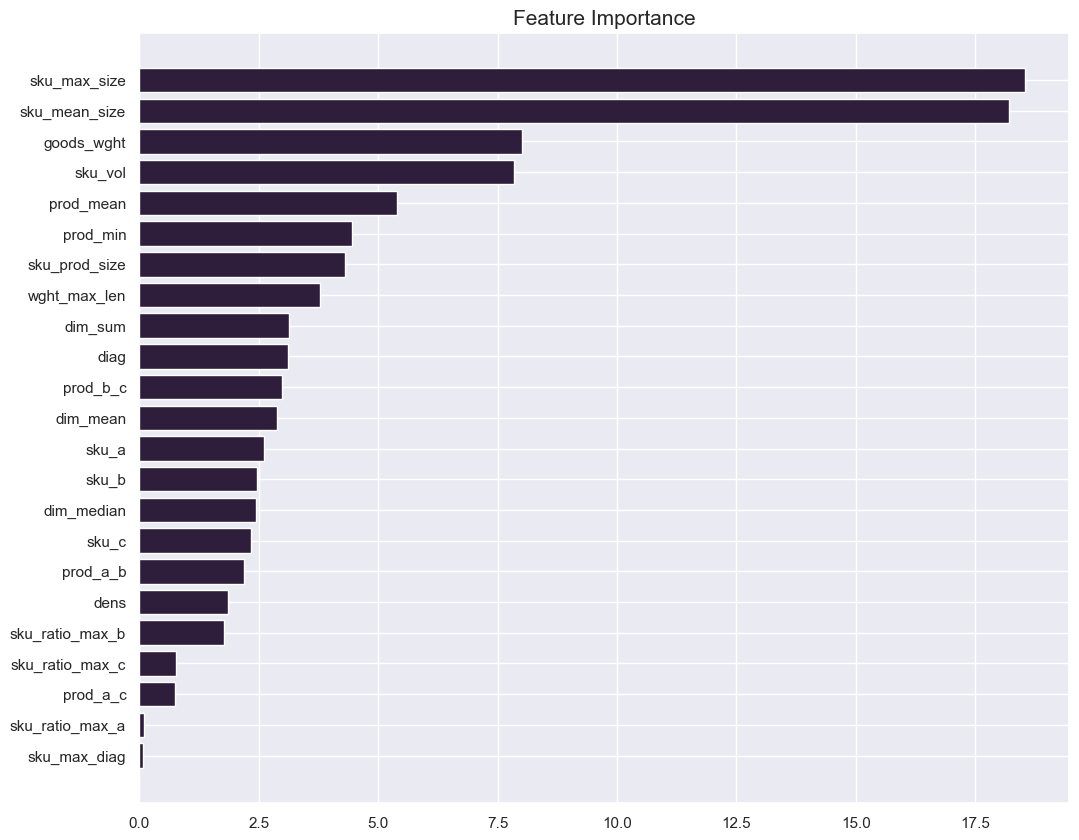

In [107]:
feature_importance = tree_pipe.named_steps['tree'].get_feature_importance()
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 10))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

In [121]:
tree_preds = tree_pipe.predict(X_test)
tree_pred_proba = tree_pipe.predict_proba(X_test)

print(f'TRAIN ACC: {accuracy_score(y_train, tree_pipe.predict(X_train))}')
print(f'TEST ACC: {accuracy_score(y_test, tree_preds)}')
print(f'TEST F1: {f1_score(y_test, tree_preds, average="weighted")}')

TRAIN ACC: 0.34669116939596284
TEST ACC: 0.34201183431952664
TEST F1: 0.34932575701293755


In [118]:
print(classification_report(y_test, tree_preds))

              precision    recall  f1-score   support

         MYA       0.42      0.68      0.52      3590
         MYB       0.60      0.33      0.43      9877
         MYC       0.49      0.37      0.42      7258
         MYD       0.26      0.22      0.24      3194
         MYE       0.11      0.07      0.08       990
         MYF       0.03      0.36      0.05       197
     NONPACK       0.84      0.10      0.17      1956
     STRETCH       0.15      0.85      0.26      1330
         YMA       0.26      0.25      0.26      1683
         YMC       0.37      0.27      0.31      1980
         YME       0.00      0.00      0.00        80
         YMF       0.29      0.11      0.16      1009
         YMG       0.00      0.00      0.00       640
         YML       0.00      0.00      0.00         2
         YMW       0.28      0.20      0.23       852
         YMX       0.00      0.00      0.00         7

    accuracy                           0.34     34645
   macro avg       0.26   

In [123]:
# делаем предсказания на тестовых данных
y_proba = tree_pipe.predict_proba(X_test[100:110])

# получаем два наиболее вероятных класса с их вероятностями
top_two = y_proba.argsort()[:, -2:]
top_two_proba = np.round(np.sort(y_proba, axis=1)[:, -2:], 2)

# выводим результаты предсказания
for i in range(len(X_test[100:110])):
    class_names = tree_pipe.classes_[top_two[i]]
    print(f"Object {i} predicted classes: {class_names}, with probabilities: {top_two_proba[i]}, {y_test.iloc[i]}")


Object 0 predicted classes: ['YMF' 'YMW'], with probabilities: [0.12 0.15], MYC
Object 1 predicted classes: ['MYC' 'YMA'], with probabilities: [0.14 0.25], MYA
Object 2 predicted classes: ['MYB' 'MYC'], with probabilities: [0.2 0.2], MYD
Object 3 predicted classes: ['MYB' 'MYA'], with probabilities: [0.16 0.46], YMW
Object 4 predicted classes: ['STRETCH' 'YMW'], with probabilities: [0.12 0.13], MYC
Object 5 predicted classes: ['MYB' 'MYA'], with probabilities: [0.25 0.26], MYB
Object 6 predicted classes: ['MYC' 'MYD'], with probabilities: [0.13 0.16], MYB
Object 7 predicted classes: ['NONPACK' 'STRETCH'], with probabilities: [0.17 0.48], MYB
Object 8 predicted classes: ['MYA' 'MYB'], with probabilities: [0.16 0.35], MYC
Object 9 predicted classes: ['MYD' 'STRETCH'], with probabilities: [0.15 0.19], MYD
